In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import utils

In [3]:
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.1


In [4]:
#读取csv文件
train_data=pd.read_csv('/home/wushukun/jupyterHome/remotePython/DeepLearning/Dataset/house-prices-advanced-regression-techniques/train.csv')
test_data=pd.read_csv('/home/wushukun/jupyterHome/remotePython/DeepLearning/Dataset/house-prices-advanced-regression-techniques/test.csv')

In [27]:
#训练数据包含1460个样本、80个特征和1个标签
train_data.shape

(1460, 81)

In [6]:
test_data.shape#训练数据比测试数据多了SalePrice这个属性

(1459, 80)

In [10]:
#查看前4个样本的特征
train_data.iloc[0:4,[0,1,2,3,-3,-2 -1]]


,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleType
0,1,60,RL,65.0,WD,WD
1,2,20,RL,80.0,WD,WD
2,3,60,RL,68.0,WD,WD
3,4,70,RL,60.0,WD,WD


In [13]:
test_data.iloc[0:4,[0,1,2,3,-3,-2 -1]]

,Id,MSSubClass,MSZoning,LotFrontage,YrSold,YrSold
0,1461,20,RH,80.0,2010,2010
1,1462,20,RL,81.0,2010,2010
2,1463,60,RL,74.0,2010,2010
3,1464,60,RL,78.0,2010,2010


In [14]:
#由于第一个特征是ID，训练时和测试时不需要ID，所以我们取[1:-1]的所有特征
#将两个表合并，相等于vstack
#这里训练数据最后一个属性SalePrice不用取
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [16]:
all_features.iloc[0:4,[0,1,2,3]]

,MSSubClass,MSZoning,LotFrontage,LotArea
0,60,RL,65.0,8450
1,20,RL,80.0,9600
2,60,RL,68.0,11250
3,70,RL,60.0,9550


#### 预处理数据

我们对连续数值的特征做标准化:设该特征在整个数据集上的均值为u,标准差为$\sigma$。
**我们可以将该特征的每个值先减去u再除以$\sigma$得到标准化后的每个特征值。**
对于缺少的特征值值,我们将其替换成该特征的均值。

##### pandas扩展

pandas所支持的数据类型有:
1.float
2.int
3.bool
4.datetime64
5.timedelta
6.category
7.object

DataFrame.dtypes返回frame中的数据类型

In [23]:
#先获取数值特征
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index

In [24]:
all_features[numeric_features]=all_features[numeric_features].apply(
                        lambda x:(x-x.mean())/(x.std()))

In [25]:
#标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺少值
all_features[numeric_features]=all_features[numeric_features].fillna(0)

接下来将离散值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

pd.get_dummies()将离散值转为one-hot encode形式。
具体参考文档:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

In [26]:
all_features=pd.get_dummies(all_features,dummy_na=True) #dummpy_na=True表示不忽视NaN
all_features.shape

(2919, 331)

最后，通过values属性得到Numpy格式的数据，并转成Tensor方便后面的训练。

In [29]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

#### 训练模型

我们使用一个基本的线性回归模型和均方函数来训练模型。

In [30]:
loss=torch.nn.MSELoss()
def get_net(feature_num):
    net=nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

定义评估模型对数均方根误差。给定预测值和对应的真实标签$y_1$。
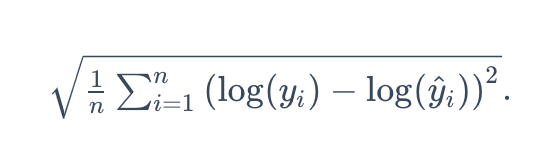

In [31]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        #将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds=torch.max(net(features),torch.tensor(1.0))
        rmse=torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

下面使用Adam优化算法进行优化。相比小批量随机梯度下降，它对学习率相对不那么敏感。

In [33]:
def train(net,train_features,train_labels,test_features,test_labels,
         num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    #这里使用Adam优化算法
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate,
                              weight_decay=weight_decay)
    net=net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

#### K折交叉验证

K折交叉验证将被用于选择模型设计并调节超参数。下面实现了一个函数，它返回第i折交叉验证时所需要的训练和验证数据。

In [36]:
#返回第k折交叉验证时所需要的训练和验证数据
def get_k_fold_data(k,i,X,y):
    #取第k个数据集为验证集合
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        #slice()函数返回一个切片对象
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            #torch.cat((A,B),dim=0):按行拼接
            X_train=torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

在k折交叉验证中我们训练K次并返回训练和验证的平均误差。

In [38]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,
                               weight_decay,batch_size)
        #取每次训练最后一次的Loss
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        
        print('fold %d,train rmse %f,valid rmse %f'%(i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

#### 模型选择

我们使用一组未经调优的超参数并计算交叉验证误差。

有时候一组参数的训练误差可以达到很低，但是在K折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察K折交叉验证上的误差是否也相应降低。

In [39]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation: avg train rmse %f,avg valid rmse %f'%(k,train_l,valid_l))

fold 0,train rmse 0.239989,valid rmse 0.221677
fold 1,train rmse 0.229189,valid rmse 0.269347
fold 2,train rmse 0.231625,valid rmse 0.238214
fold 3,train rmse 0.237867,valid rmse 0.218824
fold 4,train rmse 0.231359,valid rmse 0.259262
5-fold validation: avg train rmse 0.234006,avg valid rmse 0.241465


##### 预测

在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [42]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,
                    lr,weight_decay,batch_size):
    net=get_net(train_features.shape[1])
    train_ls,_=train(net,train_features,train_labels,None,None,
                    num_epochs,lr,weight_decay,batch_size)
    print('train rmse %f'%(train_ls[-1]))
    #detach()将变量从计算图中分离出来
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat((test_data['Id'],test_data['SalePrice']),axis=1)
    submission.to_csv('./submission.csv',index=False)

In [43]:
train_and_pred(train_features,test_features,train_labels,test_data,
              num_epochs,lr,weight_decay,batch_size)

train rmse 0.229820


### 总结

* 通过需要对真实数据做预处理
* 可以使用K折交叉验证来选择模型并调节超参数。